# CLIMADA Risk Transfer Example

This notebook demonstrates how to calculate risk transfer for a portfolio of assets affected by a *single flood event* for *Wien* using CLIMADA.

We will also introduce a risk reduction measure (Reinforcement) and observe how it impacts risk transfer and residual risk by recalculating these values.

The analysis will be conducted in **two ways**:
1. **Portfolio-level approach**: By applying a cover and deductible on the total portfolio of assets.
2. **Individual-level approach**: By applying an individual cover and deductible for each building.

In this example, we use *SaferPlaces* data to model the flood event and asset exposure from the *Wien demo*.


In [1]:
from pathlib import Path

**Define the path to DATA folder. The DATA can be downloaded from NEXTCLOUD [https://cloud.tu-braunschweig.de/f/569399210](https://cloud.tu-braunschweig.de/f/569399210)**   

In [2]:
data_path = Path('/Users/vwattin/Documents/Programming/Climate/DIRECTED/Coupling/DATA')

# Define the output folder path (used later in the script)
output_path = Path('Results')

# Create the output folder if it doesn't exist
output_path.mkdir(parents=True, exist_ok=True)

Some utility functions to import exposure and to project the flood map to create the hazard object in CLIMADA (see example `CLIMADA-simple_example1.ipynb` and `CLIMADA-simple_example2.ipynb`).

We define two functions:
- **`create_exposure_from_shp_file`**: This function loads exposure data from a shapefile.
- **`create_reduced_hazard_from_raster`**: This function loads hazard data from a raster and calculates the mean water depth around buildings.


In [3]:
from climada.entity import Exposures
import geopandas as gpd
import numpy as np
import rasterio
from rasterio.mask import mask
from shapely.geometry import mapping, box
import numpy as np
from climada.hazard import Hazard, Centroids
from scipy.sparse import csr_matrix

# Function to load exposure data
def create_exposure_from_shp_file(shape_file, value_column=None, default_value=1):
    """
    Load exposure data from a shapefile, process it to be compatible with CLIMADA, and return an Exposures object.

    Parameters:
    - shape_file: Path to the shapefile to load.
    - value_column: Column name in the shapefile to use as the exposure value.
                    If not provided or doesn't exist, the 'default_value' will be used.
    - default_value: Default value to assign if 'value_column' is not provided or doesn't exist (default is 1).

    Returns:
    - Exposures: A CLIMADA Exposures object with processed data.
    """
    
    # Load the shapefile into a GeoDataFrame
    exp_gdf = gpd.read_file(shape_file)

    # Add a 'value' column to the GeoDataFrame (required by CLIMADA)
    if value_column is None or value_column not in exp_gdf.columns:
        exp_gdf['value'] = default_value
    else:
        exp_gdf['value'] = exp_gdf[value_column]

    # Store the original geometry in a new column
    exp_gdf['geometry_polygon'] = exp_gdf['geometry']

    # Set the geometry to the centroid of the building (useful for impact calculations later on)
    exp_gdf['geometry'] = exp_gdf['geometry'].centroid

    # Reproject the centroids back to EPSG:4326 (WGS84, in degrees) - CLIMADA default CRS
    exp_gdf = exp_gdf.to_crs(4326)

    # Set latitude and longitude from geometry
    exp_gdf['latitude'] = exp_gdf['geometry'].y
    exp_gdf['longitude'] = exp_gdf['geometry'].x

    # Define the exposure object
    exp = Exposures(exp_gdf)

    # Check the exposure object for consistency
    exp.check()

    # Return the Exposures object
    return exp


# Function to load the hazard data
def create_reduced_hazard_from_raster(exp, haz_raster_full_path, buffer_distance=20, frequency=None, event_id=None):
    """
    Function to create a hazard object from a raster file by calculating the mean water depth
    around the building polygons with a specified buffer distance.

    Parameters:
    - exp: The exposure GeoDataFrame containing building geometries.
    - haz_raster_full_path: File path to the hazard raster.
    - buffer_distance: Buffer distance for calculating mean water depth around buildings (in meters).
    - frequency: Frequency of the event (default is None, if None, a frequency of 1-in-1000 year is used).
    - event_id: Event ID (default is None, if None, an ID of np.arange(n_ev) is used).

    Returns:
    - hazard object: A CLIMADA hazard object based on the raster and building geometries.
    """

    # Hardcoded parameters
    haz_type = 'RF'
    intensity_unit='m'
    n_ev=1

    # Initialize default values if none provided
    if frequency is None:
        frequency = np.ones(n_ev) / 1000  # Default frequency
    if event_id is None:
        event_id = np.arange(n_ev, dtype=int)  # Default event ID

    # Step 1: Copy Exposure Data and Prepare for Processing
    haz_dummy_gdf = exp.gdf[['geometry', 'geometry_polygon']].copy()

    # Step 2: Open the Raster File and Get CRS
    with rasterio.open(haz_raster_full_path) as src:
        raster_crs = src.crs
        raster_bounds = src.bounds
        raster_nodata = src.nodata

    # Step 3: Apply Buffer to Building Geometries and Reproject to Match Raster CRS
    if haz_dummy_gdf.crs != raster_crs:
        haz_dummy_gdf = haz_dummy_gdf.to_crs(raster_crs)
        print(f"Reprojected GeoDataFrame to match the raster CRS: {raster_crs}")
    haz_dummy_gdf['geometry_polygon_buffered'] = haz_dummy_gdf['geometry_polygon'].buffer(buffer_distance)

    # Convert raster bounds to a Shapely Polygon for intersection checking
    raster_bounds_polygon = box(raster_bounds.left, raster_bounds.bottom, raster_bounds.right, raster_bounds.top)

    # Step 4: Function to Calculate Mean Water Depth, Excluding Building Area
    def calculate_mean_water_excluding_building(geom, building_geom, src, raster_nodata, raster_bounds_polygon):
        # Check if the buffered building geometry intersects the raster area
        if geom.intersects(raster_bounds_polygon):
            buffer_minus_building = geom.difference(building_geom)
            if buffer_minus_building.is_empty:
                return 0
            geom_geojson = [mapping(buffer_minus_building)]
            out_image, _ = mask(src, geom_geojson, crop=True, nodata=raster_nodata)
            water_pixels = out_image.flatten()
            valid_water_pixels = water_pixels[(water_pixels != raster_nodata)]
            if valid_water_pixels.size == 0 or np.isnan(valid_water_pixels).all():
                return 0
            return np.nanmean(valid_water_pixels)
        else:
            return 0

    # Step 5: Apply the Mean Water Calculation to Each Buffered Building Geometry
    with rasterio.open(haz_raster_full_path) as src:
        haz_dummy_gdf['mean_water'] = haz_dummy_gdf.apply(
            lambda row: calculate_mean_water_excluding_building(
                row['geometry_polygon_buffered'], row['geometry_polygon'], src, raster_nodata, raster_bounds_polygon
            ),
            axis=1
        )

    # Step 6: Reproject Back to Geographic CRS (EPSG:4326)
    haz_dummy_gdf = haz_dummy_gdf.to_crs(4326)

    # Step 7: Create the Hazard Object for CLIMADA
    haz = Hazard(
        haz_type=haz_type,
        intensity=csr_matrix([haz_dummy_gdf["mean_water"]]),
        centroids=Centroids(lat=haz_dummy_gdf.geometry.centroid.y, lon=haz_dummy_gdf.geometry.centroid.x, crs='EPSG:4326'),
        units=intensity_unit,
        event_id=event_id,
        frequency=frequency
    )

    # Step 8: Validate the Hazard Object
    haz.check()

    return haz


Create the exposure object

In [4]:
import pandas as pd
from tabulate import tabulate

# Get the mapping file given the event and the region
exposure_file = data_path / 'Saferplaces/Exposure/DMG_RAIN110828/DMG_RAIN110828.shp'
# Load the exposure data
exp = create_exposure_from_shp_file(shape_file =  exposure_file,
                         value_column= 'exposure' 
                          )


Create the hazard object

In [5]:
# Create the hazard object
hazard_file = data_path / 'Saferplaces/Hazard/WD_RAIN110828.tif'
haz = create_reduced_hazard_from_raster(exp= exp, # Exposure object
                                      haz_raster_full_path = hazard_file
                                        )                                       


Reprojected GeoDataFrame to match the raster CRS: EPSG:32633


/var/folders/cc/c55t39cs0_7dn2cdqsg62v4c0000gp/T/ipykernel_25410/2264206562.py:137: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids=Centroids(lat=haz_dummy_gdf.geometry.centroid.y, lon=haz_dummy_gdf.geometry.centroid.x, crs='EPSG:4326'),


Create the Impact function set

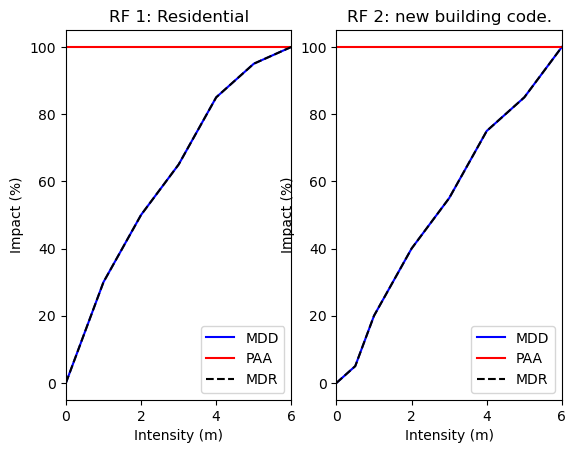

In [6]:
import numpy as np
from climada.entity import ImpactFuncSet

# Read the impact function set from excel (can also created manually)
impfset = ImpactFuncSet.from_excel(file_name = data_path / 'Shared' / 'Impact function sets' /'impact_fcn_set_Residental.xlsx' # Full path to the impact function set file
                                   )
#  Plot the impact functions
impfset.plot()

# Check the impact function set
impfset.check()

Lets define a simple measure (*Reinforcement*) to later on compare the impact with and without the measure. In the **CLIMADA framework**, [adaptation measures](https://climada-python.readthedocs.io/en/stable/tutorial/climada_entity_MeasureSet.html#measureset-class) class are defined as objects that modify exposure, hazard, or impact function set objects. 

In [7]:
from climada.entity.measures import Measure
from climada.engine import ImpactCalc

# Define the measure (Reinforcement)
meas = Measure(
    name='Reinforcement',  # The name of the measure
    haz_type='RF',  # The hazard type
    cost=1e8,  # Cost of the measure
    mdd_impact=(1, -0.1),  # Decreases mean damage by 0.1
    paa_impact=(1, -0.1),  # Decreases the percentage of affected assets by 0.1  
    hazard_inten_imp=(1, -0.2)  # Reduces intensity by 0.2
)

### METHOD 1: Calculate Impact (Risk Transfer and Residual) Based on Portfolio Cover and Deductible

In this method, we apply a single cover and deductible to the entire portfolio of assets. This approach assumes that the portfolio as a whole is insured under a single policy, with a common deductible and coverage limit.

We will calculate:
1. **Total impact**: The total damage to the portfolio without insurance.
2. **Risk transfer**: The portion of the damage covered by insurance (after applying the deductible and cover).
3. **Residual risk**: The portion of the damage not covered by insurance (remaining losses after the risk transfer).


Begin by calculating the impact object

In [8]:
from climada.engine import ImpactCalc

# Calculate the Total Damage (without insurance) impact object for the given exposure, impact function set, and hazard
impact = ImpactCalc(exp, impfset, haz).impact(save_mat=True, ignore_cover=True, ignore_deductible=True) 

In [9]:
# Save to csv (netcdf will be implemented soon)
impact.write_csv(output_path / 'example_risk_transfer_impact.csv')
# The full event/point impact matrix
impact.imp_mat

<1x303717 sparse matrix of type '<class 'numpy.float64'>'
	with 52513 stored elements in Compressed Sparse Row format>

Calculate the Impact Metrics Based on Portfolio Coverage and Deductible. We calculate the impact metrics given the coverage and deductible of the complete portfolio. 

- The **Average Annual Impact (AAI)** is computed as the total impact per event multiplied by the event's annual frequency.
- In this example, we assume a single event with an arbitrary annual frequency of 1/1000, which means the AAI is 0.1% of the total impact value.


In [10]:
# Parameters for the risk transfer
total_value = exp.gdf['value'].sum()
attachment = total_value * 0.01
cover = total_value * 0.5

# Apply a risk transfer for each event
transfer_at_event, transfer_aai_agg = impact.transfer_risk(attachment, cover)

# Print the original scenario results
print("\n--- Properties ---")
print(f"Total value of assets: {total_value:,.1f}")
print(f"Attachment: {attachment:,.1f}")
print(f"Cover: {cover:,.1f}")

print("\n--- Transfer risk ---")
print(f"Transfer at event [Event 0]: {transfer_at_event[0]:,.1f}")
print(f"Transfer AAI (Average Annual Impact): {transfer_aai_agg:,.1f}") # Average Annual Impact

# Calculate the residual risk for the original scenario
residual_at_event, residual_aai_agg = impact.residual_risk(attachment, cover)

# Print the residual risk results for the original scenario
print("\n--- Residual risk ---")
print(f"Residual at event [Event 0]: {residual_at_event[0]:,.1f}")
print(f"Residual AAI (Average Annual Impact): {residual_aai_agg:,.1f}")



--- Properties ---
Total value of assets: 68,403,984,777.1
Attachment: 684,039,847.8
Cover: 34,201,992,388.6

--- Transfer risk ---
Transfer at event [Event 0]: 865,704,799.2
Transfer AAI (Average Annual Impact): 865,704.8

--- Residual risk ---
Residual at event [Event 0]: 684,039,847.8
Residual AAI (Average Annual Impact): 684,039.8


Next, we calculate the risk transfer and residual risk based given the measure.

In [11]:
# Apply the measure to get the new exposure, impact functions, and hazard
new_exp, new_impfs, new_haz = meas.apply(exp, impfset, haz)

# Calculate the Total Damage (without insurance) for the new scenario
meas_impact = ImpactCalc(new_exp, new_impfs, new_haz).impact(save_mat=True, ignore_cover=True, ignore_deductible=True)

In [12]:
# Parameters for risk transfer after applying the measure
coverage_measure = total_value * 0.5  # 50% of total value for coverage
attachment_measure = total_value * 0.01  # 1% of total value for attachment

# Apply the risk transfer for the new scenario using the updated coverage and attachment values
new_transfer_at_event, new_transfer_aai_agg = meas_impact.transfer_risk(attachment_measure, coverage_measure)

# Print the results for the new scenario after applying the measure
print("\n--- Properties ---")
print(f"Total value of assets (after measure): {new_exp.gdf['value'].sum():,.1f}") 
print(f"Attachment: {attachment_measure:,.1f}")
print(f"Cover: {coverage_measure:,.1f}")

print("\n--- Transfer risk ---")
print(f"Transfer at event [Event 0] (after measure): {new_transfer_at_event[0]:,.1f}")
print(f"Transfer AAI (Average Annual Impact) (after measure): {new_transfer_aai_agg:,.1f}")

# Calculate the residual risk for the new scenario
new_residual_at_event, new_residual_aai_agg = meas_impact.residual_risk(attachment_measure, coverage_measure)

# Print the residual risk results for the new scenario
print("\n--- Residual risk ---")
print(f"Residual at event [Event 0] (after measure): {new_residual_at_event[0]:,.1f}")
print(f"Residual AAI (Average Annual Impact) (after measure): {new_residual_aai_agg:,.1f}")



--- Properties ---
Total value of assets (after measure): 68,403,984,777.1
Attachment: 684,039,847.8
Cover: 34,201,992,388.6

--- Transfer risk ---
Transfer at event [Event 0] (after measure): 0.0
Transfer AAI (Average Annual Impact) (after measure): 0.0

--- Residual risk ---
Residual at event [Event 0] (after measure): 304,338,559.5
Residual AAI (Average Annual Impact) (after measure): 304,338.6


### METHOD 2: Calculate Impact (Risk Transfer and Residual) Based on Individual Cover and Deductible Per Building

In this method, we apply a specific cover and deductible to each building in the portfolio. This approach assumes that each building has its own individual insurance policy, with potentially different deductibles and coverage limits.

We will calculate:
1. **Total impact**: The total damage to each building without insurance.
2. **Risk transfer**: The portion of the damage for each building that is covered by insurance, after applying its individual deductible and cover.
3. **Residual risk**: The portion of the damage for each building that is not covered by insurance (remaining losses after risk transfer).


First, we add the specific **deductible** and **coverage** columns to the exposure GeoDataFrame (`exp.gdf`). 

These columns are critical because they represent the individual insurance terms for each building. It's important that the column names are exactly **"deductible"** and **"coverage"**, as these names are referenced in other functions for calculating risk transfer and residual risk.

In [13]:
# Lets add the deductible and coverage to each exposure object
exp.gdf['deductible'] = 0.05 * exp.gdf['value']
exp.gdf['coverage'] = 0.5 * exp.gdf['value']

For this, we will derive three **Impact** objects that can be used for further analysis:

1. **Total Gross Damage**: The total damage without considering any insurance (before applying cover or deductible).
2. **Total Risk Transfer (Insurance Payout)**: The damage that is covered by insurance, accounting for the deductible and coverage limit for each building.
3. **Residual Risk (Uncovered Losses)**: The portion of the damage that remains uncovered after insurance (damage minus the risk transfer).

In [14]:
from climada.engine import ImpactCalc
import copy
import numpy as np
import scipy.sparse

def create_impact_objects(exp, impfset, haz):
    """
    Create three Impact objects: total gross damage, risk transfer (insurance payout), and residual risk (uncovered losses),
    based on the exposure, impact function set, and hazard input.

    Args:
        exp (Exposure): Exposure object with deductible and coverage information.
        impfset (ImpactFuncSet): Impact function set that links hazards to exposures.
        haz (Hazard): Hazard object containing hazard events.

    Returns:
        tuple: A tuple containing three Impact objects:
            - imp_total_damage: Impact object for total gross damage (without insurance).
            - imp_risk_transfer: Impact object for total risk transfer (accounting for deductible and coverage).
            - imp_residual_risk: Impact object for residual risk (damage not covered by insurance).
    """

    # a) Total Damage (without insurance)
    imp_total_damage = ImpactCalc(exp, impfset, haz).impact(save_mat=True, ignore_cover=True, ignore_deductible=True)
    
    # Ensure frequency is present and valid
    frequency = imp_total_damage.frequency  # Event frequencies
    
    # Extract the impact matrix for total damage (dense matrix)
    imp_tot_matrix = imp_total_damage.imp_mat.toarray()
    
    # Reshape deductible and coverage to match the impact matrix shape
    deductible = exp.gdf['deductible'].values.reshape(1, -1)  # Shape (1, n_exposures)
    coverage = exp.gdf['coverage'].values.reshape(1, -1)  # Shape (1, n_exposures)

    # b) Calculate the Risk Transfer (Insurance Payout)
    imp_net_matrix = np.minimum(np.maximum(imp_tot_matrix - deductible, 0), coverage)  # Risk transfer (insurance payout) matrix

    # c) Calculate the Residual Risk (Uncovered Losses)
    imp_uncovered_matrix = imp_tot_matrix - imp_net_matrix  # Residual risk (uncovered losses) matrix

    # Now, we can make copies of the original Impact object and modify specific attributes.
    
    # 1. Total Gross Damage
    imp_total_damage_obj = copy.deepcopy(imp_total_damage)
    
    # 2. Risk Transfer (Insurance Payout)
    imp_risk_transfer_obj = copy.deepcopy(imp_total_damage)
    imp_risk_transfer_obj.at_event = np.sum(imp_net_matrix, axis=1)  # Sum of risk transfer for each event
    imp_risk_transfer_obj.aai_agg = np.sum(imp_risk_transfer_obj.at_event * frequency)  # Average Annual Impact (AAI)
    imp_risk_transfer_obj.eai_exp = np.sum(imp_net_matrix * frequency.reshape(-1, 1), axis=0)  # Expected Annual Impact for each exposure
    imp_risk_transfer_obj.imp_mat = csr_matrix(imp_net_matrix)  # Sparse matrix for risk transfer
    
    # 3. Residual Risk (Uncovered Losses)
    imp_residual_risk_obj = copy.deepcopy(imp_total_damage)
    imp_residual_risk_obj.at_event = np.sum(imp_uncovered_matrix, axis=1)  # Sum of residual risk for each event
    imp_residual_risk_obj.aai_agg = np.sum(imp_residual_risk_obj.at_event * frequency)  # Average Annual Impact (AAI)
    imp_residual_risk_obj.eai_exp = np.sum(imp_uncovered_matrix * frequency.reshape(-1, 1), axis=0)  # Expected Annual Impact for each exposure
    imp_residual_risk_obj.imp_mat = csr_matrix(imp_uncovered_matrix)  # Sparse matrix for residual risk

    return imp_total_damage_obj, imp_risk_transfer_obj, imp_residual_risk_obj


Next, we calculate the impact objects.

In [15]:
# Assuming exp, impfset, and haz are predefined objects
imp_total_damage_obj, imp_risk_transfer_obj, imp_residual_risk_obj = create_impact_objects(exp, impfset, haz)

# Store the impact results in a dictionary for easy access in a DataFrame
metrics_df = pd.DataFrame({
    'metrics': ['Total Gross Damage', 'Risk Transfer (Insurance Payout)', 'Residual Risk (Uncovered Losses)'],
    'No Measure': [imp_total_damage_obj.at_event[0], imp_risk_transfer_obj.at_event[0], imp_residual_risk_obj.at_event[0]]
})


Now lets calculat the same values given the measure

In [16]:
# Calculate the impacts for the new scenario (after applying the measure)
meas_imp_total_damage, meas_imp_risk_transfer, meas_imp_residual_risk = create_impact_objects(new_exp, new_impfs, new_haz)

# Store the new impact results under a new column 'Facade' in the DataFrame
metrics_df['Reinforcement'] = [
    meas_imp_total_damage.at_event[0], 
    meas_imp_risk_transfer.at_event[0], 
    meas_imp_residual_risk.at_event[0]
]


Print the results

In [17]:
# Print the results tabulated and formatted nicely in billions
print(tabulate(metrics_df, headers='keys', tablefmt='fancy_grid'))

╒════╤══════════════════════════════════╤══════════════╤═════════════════╕
│    │ metrics                          │   No Measure │   Reinforcement │
╞════╪══════════════════════════════════╪══════════════╪═════════════════╡
│  0 │ Total Gross Damage               │  1.54974e+09 │     3.04339e+08 │
├────┼──────────────────────────────────┼──────────────┼─────────────────┤
│  1 │ Risk Transfer (Insurance Payout) │  8.17151e+08 │     1.17341e+08 │
├────┼──────────────────────────────────┼──────────────┼─────────────────┤
│  2 │ Residual Risk (Uncovered Losses) │  7.32594e+08 │     1.86998e+08 │
╘════╧══════════════════════════════════╧══════════════╧═════════════════╛
